# Masked Language Models are Fragment Based Drug Designers

In [63]:
from rdkit.Chem.Draw import rdMolDraw2D
from transformers import BertForMaskedLM, pipeline, PreTrainedTokenizerFast
from itertools import permutations
from tqdm import tqdm
import re
from math import factorial
import random

from rdkit import Chem
from rdkit.Chem import BRICS, AllChem

from rdkit import RDLogger           

RDLogger.DisableLog('rdApp.*')                         

In [64]:
tokenizer = PreTrainedTokenizerFast.from_pretrained('../src/FragmentBERT')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [65]:
tokenizer.mask_token = "[MASK]"
tokenizer.unk_token = "[UNK]"
tokenizer.pad_token = "[PAD]"
tokenizer.sep_token = "[SEP]"
tokenizer.cls_token = "[CLS]"

In [66]:
model = BertForMaskedLM.from_pretrained("../src/FragmentBERT/checkpoint-4251")

In [67]:
def random_enumerate(iterable):
    indices = list(range(len(iterable)))
    random.shuffle(indices)
    for i, idx in enumerate(indices):
        yield i, iterable[idx]

def to_smiles(mol: Chem.Mol) -> str:
    return Chem.MolToSmiles(mol)

def random_n_unique_shuffles(lst, n):
    return random.choices(list(set(permutations(lst))), k=n)

def fragment_augmentation(smi: str, augment: int = 5):
    mol: Chem.Mol = Chem.MolFromSmiles(smi)
    brics_bonds: list[tuple[tuple[int, int], tuple[str, str]]] = list(BRICS.FindBRICSBonds(mol))

    if len(brics_bonds) < 3 and augment > 2:
        augment = factorial(len(brics_bonds))
    
    if augment < 2:
        augment = 1
        
    augmented_brics_bonds = [list(i) for i in random_n_unique_shuffles([i[0] for i in brics_bonds], augment)]

    for _brics_bonds in augmented_brics_bonds:
        bonds: list[tuple[tuple[int, int], tuple[str, str]]] = [(i, (str(n + 1), str(n + 1))) 
                                                                for n, i in enumerate(_brics_bonds)]
        mol_frags: Chem.Mol = BRICS.BreakBRICSBonds(mol, bonds=bonds)
        yield to_smiles(mol_frags).split(".")


def encoder(frags: list[str]) -> str:
    if len(frags) == 1:
        raise ValueError('BRICS Failed') 
    pattern = re.compile(r'\[\d+\*\]')
    tokenized_fragment = ""
    for frag in frags:
        tokenized_fragment += re.sub(pattern, '[*]', frag) + " " + " ".join(pattern.findall(frag)) + " "
    return tokenized_fragment[:-1]

def extract_attachment_token(fragment):
    return re.findall(r'\d+\*', fragment)

def extract_fragments(encoded_fragment) -> str:
    return ' '.join(item for item in encoded_fragment.split() if not re.compile(r'\[\d+\*\]').match(item))


def combine_fragments(smi1:str, smi2:str, attachment_token:str) -> str|ValueError:
    # Fails to combine fragments with double bond
    m1 = Chem.MolFromSmiles(smi1) 
    m2 = Chem.MolFromSmiles(smi2) 
    rxn = AllChem.ReactionFromSmarts(f"[{attachment_token}][*:1].[{attachment_token}][*:2]>>[*:1][*:2]")
    results = rxn.RunReactants([m1, m2])
    if results:
        return Chem.MolToSmiles(results[0][0])
    raise ValueError(smi1, smi2)
    

def _decode(encoded_fragment:str) -> str | ValueError:
        s: str = extract_fragments(encoded_fragment)
        replacements: list = extract_attachment_token(encoded_fragment)
        if not replacements: 
            raise ValueError('Molecule was not fragmented')
        
        # Calculate the length of the replacement string
        replacement_length = len(replacements[0])
        index = 0
    
        # Iterate over the replacements and replace each occurrence sequentially
        while '[*]' in s:
            # Find the index of the next occurrence of '[*]'
            start_index = s.find('[*]', index)
            if start_index == -1:
                break  # Exit the loop if no more occurrences are found
    
            # Determine the replacement value
            replacement = replacements.pop(0)
    
            # Replace '[*]' with the replacement value
            s = s[:start_index+1] + replacement + s[start_index + replacement_length:]
    
            # Update the index to continue searching for the next occurrence
            index = start_index + len(replacement)
    
        return s   


def decoder(encoded_fragment):
        frags = _decode(encoded_fragment).split()
        base_fragment = frags[0]
        frags = frags[1:]
        
        condition = True
        while condition:
            for attachment_token in extract_attachment_token(base_fragment):
                for n, frag in enumerate(frags):
                    if attachment_token in frag:
                        base_fragment = combine_fragments(base_fragment, frag, attachment_token)
                        frags.remove(frag)
                        break  # Move to the next attachment token once one is found and processed
                        
            if not frags:
                break
            
            if not extract_attachment_token(base_fragment):
                break
            
        return base_fragment

In [68]:
true_smi = "C1=CC=C(C(=C1)CC(=O)O)NC2=C(C=CC=C2Cl)Cl"

In [69]:
true_canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(true_smi))
true_canon_smi

'O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl'

In [70]:
aa = encoder(list(fragment_augmentation(true_canon_smi, augment=1))[0])
aa

'[*]CC(=O)O [1*] [*]c1ccccc1[*] [1*] [3*] [*]N[*] [2*] [3*] [*]c1c(Cl)cccc1Cl [2*]'

In [79]:
task = '[*]CC(=O)O [1*] [MASK] [1*] [3*] [*]N[*] [2*] [3*] [*]c1c(Cl)cccc1Cl [2*]' # Masked [*]c1ccccc1[*]

In [82]:
top_k = 50
fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer, top_k=top_k)

In [83]:
gen_smis = []

for n, mask in tqdm(enumerate(fill_mask(task)), total=top_k):
    try:
        res = decoder(mask['sequence'])
        if res == true_canon_smi:
            print(f'[{n}] {mask} Found')
        gen_smis.append(res)
    except:
        pass

100%|██████████| 50/50 [00:00<00:00, 3885.27it/s]

[30] {'score': 0.0015672273002564907, 'token': 30, 'token_str': '[*]c1ccccc1[*]', 'sequence': '[*]CC(=O)O [1*] [*]c1ccccc1[*] [1*] [3*] [*]N[*] [2*] [3*] [*]c1c(Cl)cccc1Cl [2*]'} Found


In [84]:
gen_mols = list(map(Chem.MolFromSmiles, gen_smis))

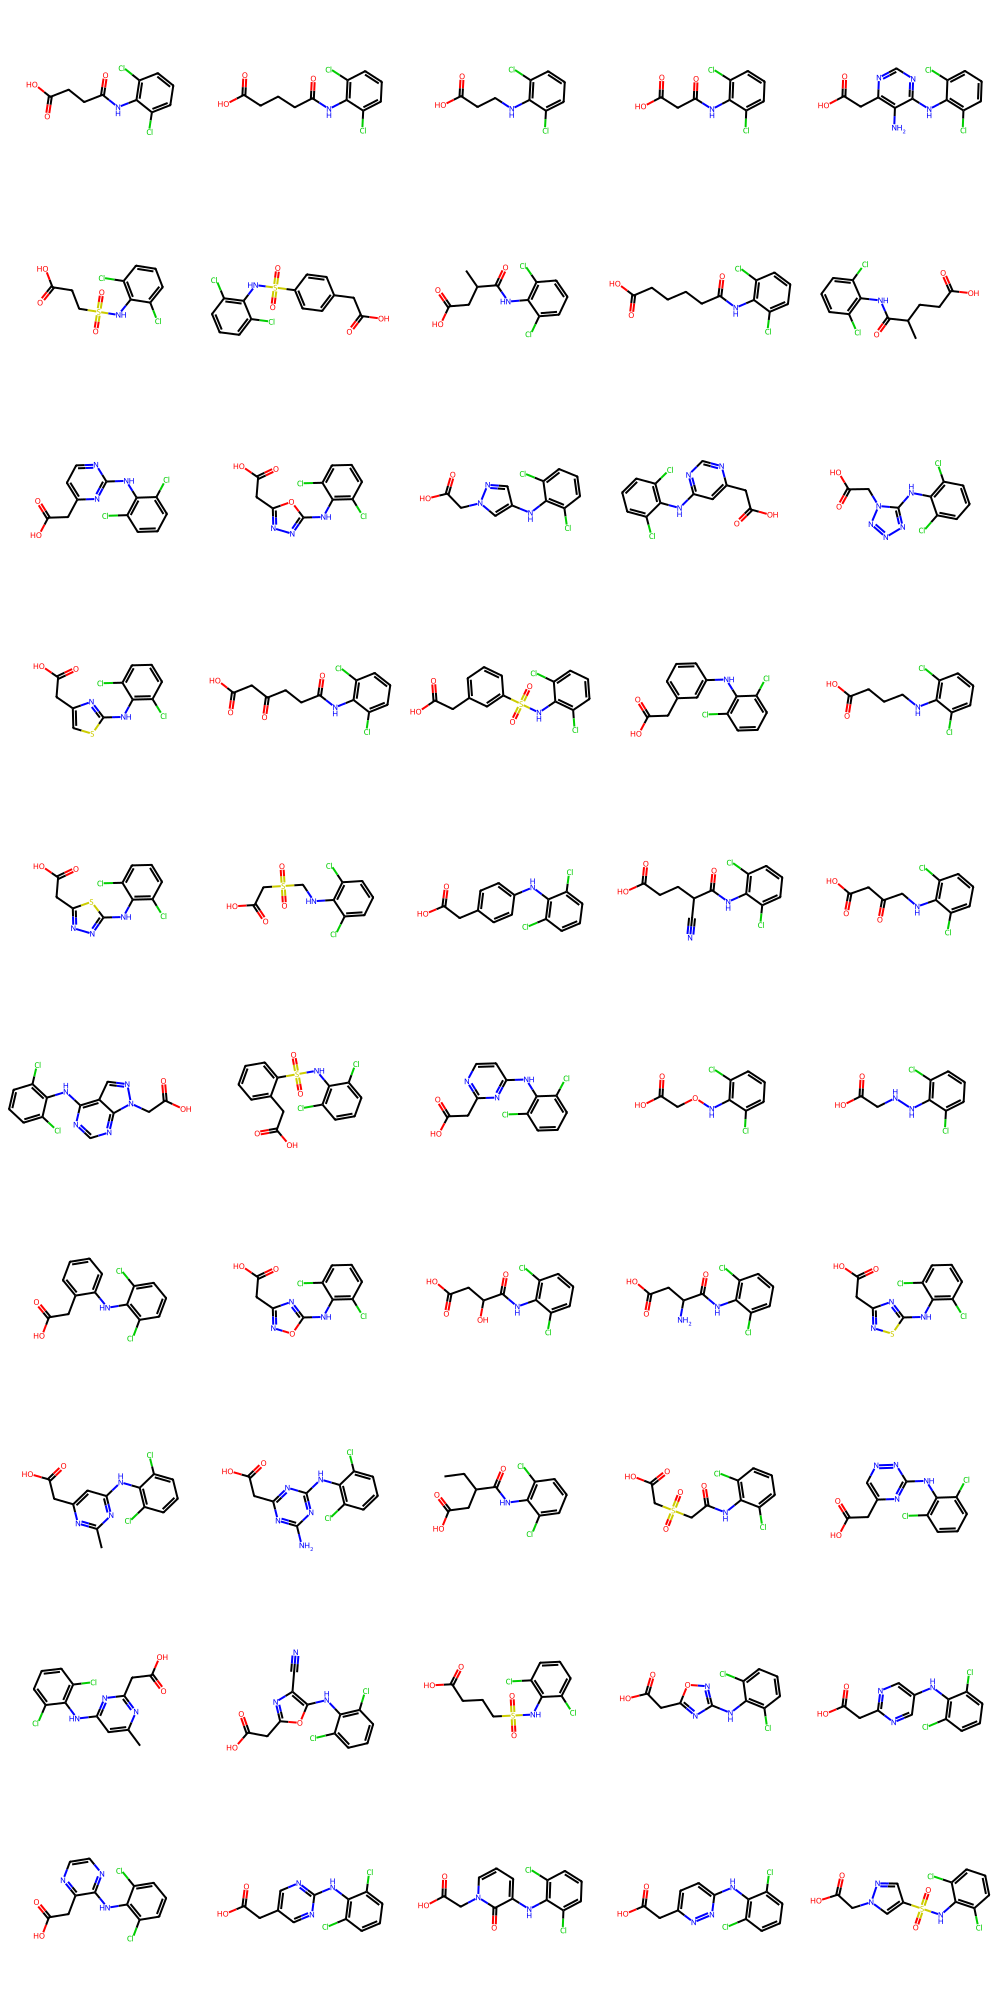

In [85]:
Chem.Draw.MolsToGridImage(gen_mols, maxMols=50, molsPerRow=5)